In [1]:
'''
need to set up env variable before running notebook

terminal command: export PYSYN_CDBS=/Users/angelachawla/Documents/research/pwv_noise_removal/Data/HST_data/grp/redcat/trds
or: point towards correct directory. var name must be PYSYN_CDBS
'''

import numpy as np
from astropy.io import ascii
from pylab import *
from astropy.table import Table, vstack
import pandas as pd
from expecto import get_spectrum
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.stats import binned_statistic as bin
from itertools import product
import os
%run Interpolate_final_v2.ipynb
%run GetSpectra_final_v2.ipynb
%run Binning_final_v2.ipynb
%run AddNoise_final_v2.ipynb
import batman

/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/angelachawla/Documents/research/pwv_noise_removal/Data/HST_data/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
#pip install batman-package

In [3]:
#pip unint

In [4]:
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

'''
reads in .dat files. col1 is wavelength, col2 is transmission. Files are labeled with water content level in mm 
water content levels are listed in the array above. resolution is 200,000.
'''


d = {}
i=0
for n in water_array:
    water_content = str(water_array[i])
    d["data"+water_content] = ascii.read("../Data/transmission{0}_hi_res.dat".format(water_content))

    #d["data"+water_content] = ascii.read("../Data/transmission1.0_hi_res.dat")
    d["data"+water_content+"_pd"] = d["data"+water_content].to_pandas()
    #print(d["data"+water_content+"_pd"])
    i+=1

In [5]:
'''
for loop creates transmission values in shape necessary for interpolation function
'''
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

flux_array = []
i=0
for n in water_array:
    water_array_i = str(water_array[i])
    d["flux"+water_array_i] = np.array(d["data"+water_array_i+"_pd"]["col2"])
    flux_array.append(d["flux"+water_array_i])
    i+=1

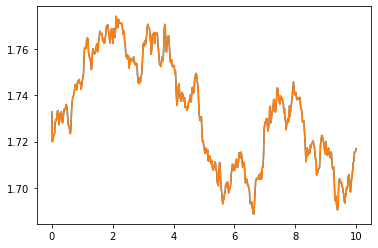

In [6]:
timestamps = np.linspace(0,10,540) #time in hours
t, target_star_pwv, target_star_phase, target_star_mean = power_spectrum(12000, 1, 24000, timestamps, mean = 2)
t1, comparison_star_pwv, _, _ = power_spectrum(12000, 1, 24000, timestamps, mean = target_star_mean, target = False, phase = target_star_phase, separation = 0)

plt.plot(t, target_star_pwv)
plt.plot(t, comparison_star_pwv)
plt.show()


In [7]:
water_world_abs1 = ascii.read("../Data/water_world_abs1.dat")
water_world_abs2 = ascii.read("../Data/water_world_abs2.dat")
water_world_abs3 = ascii.read("../Data/water_world_abs3.dat")
water_world_abs4 = ascii.read("../Data/water_world_abs4.dat")

hot_jupiter_abs1 = ascii.read("../Data/hot_jupiter_abs1.dat")
hot_jupiter_abs2 = ascii.read("../Data/hot_jupiter_abs2.dat")
hot_jupiter_abs3 = ascii.read("../Data/hot_jupiter_abs3.dat")
hot_jupiter_abs4 = ascii.read("../Data/hot_jupiter_abs4.dat")

warm_jupiter_abs1 = ascii.read("../Data/warm_jupiter_abs1.dat")
warm_jupiter_abs2 = ascii.read("../Data/warm_jupiter_abs2.dat")
warm_jupiter_abs3 = ascii.read("../Data/warm_jupiter_abs3.dat")
warm_jupiter_abs4 = ascii.read("../Data/warm_jupiter_abs4.dat")

In [8]:
wave_range_abs1 = bin_array(.6, 1, 200)
wave_range_abs2 = bin_array(1, 1.25, 200)
wave_range_abs3 = bin_array(1.25, 1.56, 200)
wave_range_abs4 = bin_array(1.56, 2.1, 200)

In [9]:
params_hot_jupiter = batman.TransitParams()       #object to store transit parameters
params_hot_jupiter.t0 = 0.                        #time of inferior conjunction
params_hot_jupiter.per = 4.7361                       #orbital period 

# assume rp of .07 for now
params_hot_jupiter.rp = 0.04644                       #planet radi`us (in units of stellar radii)
#at each wavelength, add transit depth for atm. Will alter rp parameter
#change in atm depth in ppm
#Depth is rp^2 (because it's in units of solar radii)
#As such, rp is sqrt of depth



params_hot_jupiter.a = 4.98                        #semi-major axis (in units of stellar radii)
params_hot_jupiter.inc = 85.3                      #orbital inclination (in degrees)
params_hot_jupiter.ecc = 0.                       #eccentricity
params_hot_jupiter.w = 90.                        #longitude of periastron (in degrees)
params_hot_jupiter.limb_dark = "linear"        #limb darkening model
params_hot_jupiter.u = [0.5]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.5, 0.5, 540)  #times at which to calculate light curve
model_hot_jupiter = batman.TransitModel(params_hot_jupiter, t)    #initializes model

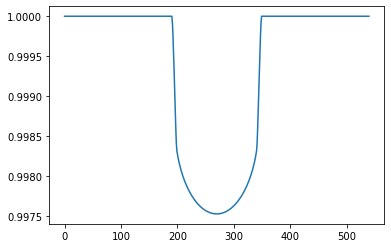

In [10]:

transit_test = model_hot_jupiter.light_curve(params_hot_jupiter)
plt.plot(transit_test)

#transit[0:150]

In [12]:
spectrum = get_spectrum(T_eff=4000, log_g=4.5, cache=False)

URLError: <urlopen error ftp error: timeout('timed out')>

In [11]:
target_spec = spectrum(4000, 7)
#ref_spec_3000 = spectrum(3000, 7)
#ref_spec_5000 = spectrum(5000, 7)
#ref_spec_7000 = spectrum(7000, 7)

URLError: <urlopen error ftp error: timeout('timed out')>

In [33]:
def division_noise_transit(target_array, ref_array, atm, params):
    new_array1 = []
    bin_size_array = [target_array[1][1]-target_array[1][0]]
    
    t = np.linspace(-0.5, 0.5, 540)
    #print("right function!")
    bulk_transit_depth = params.rp**2
    print("bulk_transit_depth: "+str(bulk_transit_depth))
    print("bulk_rp: "+str(params.rp))
    #new_array2
    i=0
    for n in target_array[0][0]:
        if i >= len(atm["col5"]):
            break
        
        bin_size = target_array[1][i+1]-target_array[1][i]
        #print("bin size: "+str(bin_size))
        bin_size_array.append(bin_size)
        target_array_i = np.array(target_array[0][:,i])
        #print(target_array_i[50:60])
        #print("original target array"+str(target_array_i[0:10]))
        
        #adding transit
        atm_transit_i = atm["col5"][i]/10**6
        #print("atm transit: "+ str(atm_transit_i))
        #print("atm depth"+str(atm_transit_i))
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        #print("total transit depth: "+ str(total_transit_depth))
        rp_i = np.sqrt(total_transit_depth)
        #print("rp i : "+ str(rp_i))
        params.rp = rp_i
        #print("edited param : "+ str(params.rp))
        #print("rp"+str(params.rp))
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        #print("transit model"+str(transit[500:510]))
        #plt.plot(transit)
        
        #flux = stellar_flux_value*transmission
        transit_flux = transit*target_array_i
        plt.plot(transit_flux)
        #print("flux with transit"+str(transit_flux[0:10]))
        
        
        ref_array_i = np.array(ref_array[0][:,i])
        #print(ref_array_i[50:60])
        target_noise = photon_noise(transit_flux, bin_size)
        #print("target_noise: "+str(target_noise))
        ref_noise = photon_noise(ref_array_i, bin_size)
        #print("ref_noise: "+str(ref_noise))
        noisy_target_i = target_noise*transit_flux
        #plt.plot(noisy_target_i)
        #print("target_noisy flux: "+str(noisy_target_i))
        noisy_ref_i = ref_noise*ref_array_i
        #print("ref_noisy flux: "+str(noisy_ref_i))
        divided_i = noisy_target_i/noisy_ref_i
        #plt.plot(divided_i)
        #print("div_noisy flux: "+str(divided_i))
        new_array1.append(divided_i)
        i+=1
        #if i == 3:
            #break
    return new_array1

#cold_star_abs1_test3[:,0]


In [38]:
#params_hot_jupiter.rp = 0.04644  
#divided_hot_jupiter_abs1_3000 = bin_divide(target_spec, ref_spec_3000, target_star_pwv, comparison_star_pwv, .6, 1, hot_jupiter_abs1, params_hot_jupiter)
'''
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs2_3000 = bin_divide(target_spec, ref_spec_3000, target_star_pwv, comparison_star_pwv, 1, 1.25, hot_jupiter_abs2, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs3_3000 = bin_divide(target_spec, ref_spec_3000, target_star_pwv, comparison_star_pwv, 1.25, 1.56, hot_jupiter_abs3, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs4_3000 = bin_divide(target_spec, ref_spec_3000, target_star_pwv, comparison_star_pwv, 1.56, 2.1, hot_jupiter_abs4, params_hot_jupiter)
'''

'\nparams_hot_jupiter.rp = 0.04644\ndivided_hot_jupiter_abs2_3000 = bin_divide(target_spec, ref_spec_3000, target_star_pwv, comparison_star_pwv, 1, 1.25, hot_jupiter_abs2, params_hot_jupiter)\nparams_hot_jupiter.rp = 0.04644\ndivided_hot_jupiter_abs3_3000 = bin_divide(target_spec, ref_spec_3000, target_star_pwv, comparison_star_pwv, 1.25, 1.56, hot_jupiter_abs3, params_hot_jupiter)\nparams_hot_jupiter.rp = 0.04644\ndivided_hot_jupiter_abs4_3000 = bin_divide(target_spec, ref_spec_3000, target_star_pwv, comparison_star_pwv, 1.56, 2.1, hot_jupiter_abs4, params_hot_jupiter)\n'

In [39]:
normalized1_3000 = normalize(divided_hot_jupiter_abs1_3000)
normalized2_3000 = normalize(divided_hot_jupiter_abs2_3000)
normalized3_3000 = normalize(divided_hot_jupiter_abs3_3000)
normalized4_3000 = normalize(divided_hot_jupiter_abs4_3000)

#plt.plot(divided_hot_jupiter_abs1_3000[80])


In [41]:
'''
d = {}
i=0
for n in water_array:
    water_content = str(water_array[i])
    d["data"+water_content] = ascii.read("transmission{0}_hi_res.dat".format(water_content))
    d["data"+water_content+"_pd"] = d["data"+water_content].to_pandas()
    #print(d["data"+water_content+"_pd"])
    i+=1
'''

d_model = {}

def depth_fit(diff_array, exo_type, ref_temp, abs_wave):
    
    if abs_wave == 1:
        wave_range = wave_range_abs1
        range_value = 20
    elif abs_wave == 2:
        wave_range = wave_range_abs2
        range_value = 8
    elif abs_wave == 3:
        wave_range = wave_range_abs3
        range_value = 8
    else:
        wave_range = wave_range_abs4
        range_value = 11
        
    if exo_type == "hot_jupiter":
        times = np.linspace(-0.5, 0.5, 1000)
    else:
        times = np.linspace(-0.25, 0.25, 1000)
    
    depth_array = []
    std_dev_array = []
    df_array = []
    wavelength_array = []
    i=0
    
    #times = 
    for n in diff_array:
        #wave_range = wave_range_abs1
        wavelength = wave_range[i]
        
        wave_rounded = np.round(wavelength, 4)
        print(wave_rounded)
        d_model["depth"+str(exo_type)+str(wave_rounded)+str(ref_temp)], d_model["std"+str(exo_type)+str(wave_rounded)+str(ref_temp)], d_model["df"+str(exo_type)+str(wave_rounded)+str(ref_temp)] = fit_lightcurve(times, diff_array[i]+1)
        depth_array.append(d_model["depth"+str(exo_type)+str(wave_rounded)+str(ref_temp)])
        print(d_model["depth"+str(exo_type)+str(wave_rounded)+str(ref_temp)])
        std_dev_array.append(d_model["std"+str(exo_type)+str(wave_rounded)+str(ref_temp)])
        df_array.append(d_model["df"+str(exo_type)+str(wave_rounded)+str(ref_temp)])
        wavelength_array.append(wavelength)
        
        
        i+=1
    
    return np.array(depth_array), np.array(std_dev_array)*np.sqrt(2), np.array(df_array), np.array(wavelength_array)

In [43]:
%run Model.ipynb
model_nosep_abs1_3000 = depth_fit(normalized1_3000, "hot_jupiter", 8000, 1)
model_nosep_abs2_3000 = depth_fit(normalized1_3000, "hot_jupiter", 8000, 2)
model_nosep_abs3_3000 = depth_fit(normalized1_3000, "hot_jupiter", 8000, 3)
model_nosep_abs4_3000 = depth_fit(normalized1_3000, "hot_jupiter", 8000, 4)

0.6


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

973.4802119663983
0.603


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

962.600239871351
0.606


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

985.7344242765578
0.609


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

974.4453536065682
0.6121


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

953.128840147765
0.6152


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

996.585136235705
0.6182


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

999.0277764428492
0.6213


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1042.5661830401357
0.6244


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

973.6045252915699
0.6275


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

966.0363022197355
0.6307


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

974.1052735565778
0.6338


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

945.5970398270808
0.637


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

955.0931988181967
0.6402


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

950.7339887913771
0.6434


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

966.7407460035552
0.6466


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

954.2263808092922
0.6498


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

959.8800132778152
0.6531


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

939.9565779605847
0.6564


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

946.1389145027114
0.6596


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

952.065542675471
0.6629


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

957.1159984021043
0.6663


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

945.9697758196278
0.6696


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

967.6354237559405
0.6729


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

968.9091107558709
0.6763


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

956.9245539546955
0.6797


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

962.5071211242216
0.6831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

956.5171545221314
0.6865


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

975.8749282870046
0.6899


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

949.5158981999305
0.6934


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

937.188695653959
0.6968


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

937.6477220209332
0.7003


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

934.254510889505
0.7038


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

939.0687158079929
0.7073


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

946.6440834396042
0.7109


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

948.9763461180419
0.7144


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

945.1066725450182
0.718


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

940.1537623600982
0.7216


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

935.5122258971147
0.7252


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

938.1897189575639
0.7288


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

935.6255961235184
0.7325


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

925.7580445527915
0.7361


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.9552289476566
0.7398


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.2843896012604
0.7435


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.678804084596
0.7472


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.5959673262626
0.751


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

929.180424592224
0.7547


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

926.6819934960222
0.7585


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

939.1654712457092
0.7623


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

937.1557696602966
0.7661


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

933.3387645193269
0.7699


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

931.7427264398432
0.7738


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

931.0227340749077
0.7777


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

927.1952961671926
0.7815


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

926.7973507280636
0.7855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

925.0702740697906
0.7894


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

931.9439943934906
0.7933


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

926.033323643196
0.7973


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.5667953987677
0.8013


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

922.5498290251164
0.8053


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.1736875204004
0.8093


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.6606097392373
0.8134


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

922.4132708371584
0.8174


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

919.0130560758786
0.8215


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

921.1887932927742
0.8256


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.0586534079597
0.8297


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

925.0771033903815
0.8339


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

921.112959409476
0.8381


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.0886737430776
0.8423


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

925.7688729924146
0.8465


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

925.1895643019673
0.8507


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.1078653396238
0.855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

928.0791497715351
0.8592


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.8710722953535
0.8635


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

919.7171424796944
0.8678


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.8471758989267
0.8722


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

921.9043213542222
0.8765


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.6710583099183
0.8809


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.735090862859
0.8853


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.7172667581546
0.8898


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

918.761526528909
0.8942


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.0158539950445
0.8987


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.1264602790084
0.9032


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

925.5507987687766
0.9077


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

921.2242581070443
0.9122


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

924.3179989968841
0.9168


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

922.22630625953
0.9214


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.6488459432605
0.926


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.3114009474123
0.9306


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.7901904865514
0.9353


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.8693955931045
0.9399


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

923.8151284584891
0.9446


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.4961981451474
0.9494


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.317066418599
0.9541


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

919.21496036815
0.9589


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

919.4068014704209
0.9637


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

921.4842130414374
0.9685


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

918.6269185494496
0.9733


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

916.2595901588365
0.9782


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.6588957541021
0.9831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.8559280125364
0.988


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

919.5652354176826
0.9929


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

920.181220036491
1


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

974.0913095976716
1.005


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

962.4095412625229
1.01


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

974.6172121769525
1.0151


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

970.5564852641049
1.0202


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

952.3935257587319
1.0253


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

997.7812524199472
1.0304


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

989.7375765309014
1.0355


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1038.1372819423957
1.0407


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

971.5971873565957
1.0459


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

964.0322483080754
1.0511


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

976.5419954414822
1.0564


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

944.6627769761974
1.0617


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

951.0371927929541
1.067


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

949.9183262828801
1.0723


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

emcee: Exception while calling your likelihood function:
  params: [[ 0.03098505 -2.44829702]
 [ 0.03121202 -2.46947433]
 [ 0.03110092 -2.42827649]
 [ 0.03156308 -2.47837339]
 [ 0.03078537 -2.47198548]
 [ 0.03032635 -2.45865306]
 [ 0.03107893 -2.46249553]
 [ 0.03152804 -2.46204037]
 [ 0.03060249 -2.47836894]
 [ 0.0321282  -2.46422354]
 [ 0.03051284 -2.46138937]
 [ 0.03333881 -2.47120725]
 [ 0.03061289 -2.4807833 ]
 [ 0.03129188 -2.45739278]
 [ 0.03014097 -2.46295928]
 [ 0.03050936 -2.47622578]
 [ 0.03036198 -2.46645585]
 [ 0.03072472 -2.48709604]
 [ 0.03138329 -2.46060029]
 [ 0.03265782 -2.4823442 ]
 [ 0.03142315 -2.46994179]
 [ 0.03408112 -2.4632258 ]
 [ 0.03032644 -2.47922978]
 [ 0.03094963 -2.45570027]
 [ 0.03366    -2.47906473]]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/tchawla/anaconda3/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/h_/vkbcrvtd39b6btnqzmk30tqm0000gr/T/ipykernel_72515/3921816434.py", line 96, in lnposterior
    lnp = self.lnlikelihood(pv) + self.lnprior(pv)
  File "/var/folders/h_/vkbcrvtd39b6btnqzmk30tqm0000gr/T/ipykernel_72515/3921816434.py", line 90, in lnlikelihood
    flux_m = self.flux_model(pv)
  File "/var/folders/h_/vkbcrvtd39b6btnqzmk30tqm0000gr/T/ipykernel_72515/3921816434.py", line 77, in flux_model
    return self.transit_model(pv) * self.baseline(pv)
  File "/var/folders/h_/vkbcrvtd39b6btnqzmk30tqm0000gr/T/ipykernel_72515/3921816434.py", line 70, in transit_model
    model.append(self.m.light_curve(self.params))
  File "/Users/tchawla/anaconda3/lib/python3.10/site-packages/batman/transitmodel.py", line 259, in light_curve
    elif self.limb_dark == "linear": lc = _quadratic_ld._qu

KeyboardInterrupt: 

In [19]:
params_hot_jupiter.rp = 0.04644  
divided_hot_jupiter_abs1_5000 = bin_divide(target_spec, ref_spec_5000, target_star_pwv, comparison_star_pwv, .6, 1, hot_jupiter_abs1, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs2_5000 = bin_divide(target_spec, ref_spec_5000, target_star_pwv, comparison_star_pwv, 1, 1.25, hot_jupiter_abs2, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs3_5000 = bin_divide(target_spec, ref_spec_5000, target_star_pwv, comparison_star_pwv, 1.25, 1.56, hot_jupiter_abs3, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs4_5000 = bin_divide(target_spec, ref_spec_5000, target_star_pwv, comparison_star_pwv, 1.56, 2.1, hot_jupiter_abs4, params_hot_jupiter)


KeyboardInterrupt: 

In [ ]:
params_hot_jupiter.rp = 0.04644  
divided_hot_jupiter_abs1_7000 = bin_divide(target_spec, ref_spec_7000, target_star_pwv, comparison_star_pwv, .6, 1, hot_jupiter_abs1, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs2_7000 = bin_divide(target_spec, ref_spec_7000, target_star_pwv, comparison_star_pwv, 1, 1.25, hot_jupiter_abs2, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs3_7000 = bin_divide(target_spec, ref_spec_7000, target_star_pwv, comparison_star_pwv, 1.25, 1.56, hot_jupiter_abs3, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs4_7000 = bin_divide(target_spec, ref_spec_7000, target_star_pwv, comparison_star_pwv, 1.56, 2.1, hot_jupiter_abs4, params_hot_jupiter)
